<img src='images/Northwind_ERD_updated.png.'>

<a href='#2.0-Initial-Question'>**2.0 Initial Question**</a>

<a href='#2.1-Initial-Hypothesis'>**2.1 Initial Hypothesis**</a>
- <a href='#2.1.1-Null-Hypothesis'>2.1.1 Null Hypothesis</a>
- <a href='#2.1.2-Alternative-Hypothesis'>2.1.2 Alternative Hypothesis</a>
- <a href='#2.1.3-Features'>2.1.3 Features</a>
- <a href='#2.1.4-Target-Variable'>2.1.4 Target Variable</a>

<a href='#2.2-Methodology'>**2.2 Methodology**</a>
- <a href='#2.2.1-Obtain-Data'>2.2.1 Obtain Data</a>
- <a href='#2.2.2-Scrub-Data'>2.2.2 Scrub Data</a>
    - <a href='#2.2.2.1-Manage-n/a-data-types'>2.2.2.1 Manage n/a data types</a>
    - <a href='#2.2.2.2-Remove-duplicate-data'>2.2.2.2 Remove duplicate data</a>
    - <a href='#2.2.2.3-Manage-data-types'>2.2.2.3 Manage data types</a>
    - <a href='#2.2.2.4-Remove-outliers'>2.2.2.4 Remove outliers</a>
- <a href='#2.2.3-Explore-Data'>2.2.3 Explore Data</a>
    - <a href='#2.2.3.1-Visualize-data'>2.2.3.1 Visualize data</a>
    - <a href='#2.2.3.2-Transform-data'>2.2.3.2 Transform data</a>
    - <a href='#2.2.3.3-Sort-data-/-Prepare-data-for-testing'>2.2.3.3 Sort data / Prepare data for testing</a>
    - <a href='#2.2.3.4-Develop-feature'>2.2.3.4 Develop Feature</a>
- <a href='#2.2.4-Model-Data'>2.2.4 Model Data</a>
    - <a href='#2.2.4.1-Check-for-data-normality'>2.2.4.1 Check for data normality</a>
    - <a href='#2.2.4.2-Standard-deviation-and-other-basic-statistics'>2.2.4.2 Standard deviation and other basic statistics</a>
    - <a href='#2.2.4.3-Statistical-test'>2.2.4.3 Statistical test</a>
    - <a href='#2.2.4.4-Verification-techniques'>2.2.4.4 Verification techniques</a>
        - <a href='#2.2.4.4.1-Nonparametric-testing-and-confirmatory-testing'>2.2.4.4.1 Nonparametric testing</a>
        - <a href='#2.2.4.4.2-Effect-size'>2.2.4.4.2 Effect size</a>
        - <a href='#2.2.4.4.3-Error'>2.2.4.4.3 Error</a>
- <a href='#2.2.5-Interpret-Model'>2.2.5 Interpret Model</a>
    - <a href='#2.2.5.1-Extension-of-acquired-knowledge'>2.2.5.1 Extension of acquired knowledge</a>
    
<a href='#2.3-Results'>**2.3 Results**</a>

<a href='#2.4-Conclusions'>**2.4 Conclusions**</a>

- <a href='#2.4.1-Actionable-Items-and-Insights'>2.4.1 Actionable Items and Insights</a>
- <a href='#2.4.2-Additional-Visuals'>2.4.2 Additional Visuals</a>

<a href='#2.5-Future-Work'>**2.5 Future Work**</a>

<a href='#2.6-References'>**2.6 References**</a>

# 2.0 Initial Question<a id='Initial Question'></a>

### Does reorder and shipping company affect customer spending on an order? Which shipping company is best for what level of reorder?

# 2.1 Initial Hypothesis<a id='Initial Hypothesis'></a>

### 2.1.1 Null Hypothesis<a id='Null Hypothesis'></a>

H0: no effect - there is no change to spending based on reorder or frieght costs

### 2.1.2 Alternative Hypothesis<a id='Alternative Hypothesis'></a>

HA: there is an effect - there is a change to spending based on reorder or frieght costs

### 2.1.3 Features<a id='Features'></a>

: spending

### 2.1.4 Target Variable<a id='Target Variable'></a>

: reorder/frieght

# 2.2 Methodology<a id='Methodology'></a>

To evaluate, I have chosen to use the following steps:
- 2.2.1 Obtain Data
- 2.2.2 Scrub Data
- 2.2.3 Explore Data
- 2.2.4 Model Data
- 2.2.5 Interpret Model

I have found that the OSEMN method explains the data science process, and gives context to exploring data.

## 2.2.1 Obtain Data<a id='Obtain Data'></a>

In [1]:
# develop class
pass

In [2]:
# import py file
from classes import Pvalue

In [3]:
# import libraries
import pandas as pd
import sqlite3

import numpy as np
from numpy import std, mean, sqrt
import scipy.stats as stats
from scipy.stats import wilcoxon
from scipy.stats import chisquare
from statsmodels.stats.power import tt_ind_solve_power
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

import matplotlib.pyplot as plt
%matplotlib inline
# plt.style.use('Solarize_Light2')
import seaborn as sns

idx = pd.IndexSlice

In [4]:
# import data
conn = sqlite3.Connection('Northwind_small.sqlite')
cur = conn.cursor()

# All data
cur.execute("""SELECT 'Order'.Id, OrderDate, Freight, ReorderLevel, Product.UnitPrice*Quantity as ItemTotal, OrderDetail.ProductId, OrderDetail.Discount, Shipper.CompanyName
               FROM OrderDetail
               LEFT JOIN 'Order' ON OrderDetail.OrderID = 'Order'.Id
               JOIN Product ON OrderDetail.ProductId = Product.Id
               JOIN Shipper ON 'Order'.ShipVia = Shipper.Id
               ;""")
df = pd.DataFrame(cur.fetchall())
df.columns = [x[0] for x in cur.description]
df.head()

,Id,OrderDate,Freight,ReorderLevel,ItemTotal,ProductId,Discount,CompanyName
0,10248,2012-07-04,32.38,30,252.00,11,0.0,Federal Shipping
1,10248,2012-07-04,32.38,0,140.00,42,0.0,Federal Shipping
2,10248,2012-07-04,32.38,0,174.00,72,0.0,Federal Shipping
3,10249,2012-07-05,11.61,0,209.25,14,0.0,Speedy Express
4,10249,2012-07-05,11.61,10,2120.00,51,0.0,Speedy Express


In [5]:
multi = df.copy(deep=True)
mulit = multi.set_index(['Id', 'ProductId', 'ReorderLevel', 'CompanyName'], inplace=True)
multi.head()

OrderDate  Freight  ItemTotal  \
Id    ProductId ReorderLevel CompanyName                                        
10248 11        30           Federal Shipping  2012-07-04    32.38     252.00   
      42        0            Federal Shipping  2012-07-04    32.38     140.00   
      72        0            Federal Shipping  2012-07-04    32.38     174.00   
10249 14        0            Speedy Express    2012-07-05    11.61     209.25   
      51        10           Speedy Express    2012-07-05    11.61    2120.00   

                                               Discount  
Id    ProductId ReorderLevel CompanyName                 
10248 11        30           Federal Shipping       0.0  
      42        0            Federal Shipping       0.0  
      72        0            Federal Shipping       0.0  
10249 14        0            Speedy Express         0.0  
      51        10           Speedy Express         0.0

Initial observations of data go here

## 2.2.2 Scrub Data<a id='Scrub Data'></a>

The following scrubbing techniques were applied to the original data:
- 2.2.2.1 Manage n/a data types
- 2.2.2.2 Remove duplicate rows
- 2.2.2.3 Manage data types
- 2.2.2.4 Remove outliers

### 2.2.2.1 Manage n/a data types<a id='Manage n/a data types'></a>

In [6]:
# nans identification
print(len(df))
df.isna().sum()

2155


Id              0
OrderDate       0
Freight         0
ReorderLevel    0
ItemTotal       0
ProductId       0
Discount        0
CompanyName     0
dtype: int64

### 2.2.2.2 Remove duplicate data<a id='Remove duplicate data'></a>

In [7]:
# identification of duplicate data
print('duplicated rows: ' + str(df.duplicated().sum()))

duplicated rows: 0


In [8]:
# code to drop duplicate row if necessary
# df.drop_duplicates(inplace=True)
# print('duplicated rows: ' + str(df.duplicated().sum()))

### 2.2.2.3 Manage data types<a id='Manage data types'></a>

In [9]:
# data type identification
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 8 columns):
Id              2155 non-null int64
OrderDate       2155 non-null object
Freight         2155 non-null float64
ReorderLevel    2155 non-null int64
ItemTotal       2155 non-null float64
ProductId       2155 non-null int64
Discount        2155 non-null float64
CompanyName     2155 non-null object
dtypes: float64(3), int64(3), object(2)
memory usage: 134.8+ KB


In [10]:
# correction to data type if necessary
# df['CompanyName'] = df['CompanyName'].astype('category')

In [11]:
# verification of correction to data type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 8 columns):
Id              2155 non-null int64
OrderDate       2155 non-null object
Freight         2155 non-null float64
ReorderLevel    2155 non-null int64
ItemTotal       2155 non-null float64
ProductId       2155 non-null int64
Discount        2155 non-null float64
CompanyName     2155 non-null object
dtypes: float64(3), int64(3), object(2)
memory usage: 134.8+ KB


### 2.2.2.4 Remove outliers<a id='Remove outliers'></a>

## 2.2.3 Explore Data<a id='Explore Data'></a>

For a quick preview of what we have to work with, we'll use the describe method.

- 2.2.3.1 Visualize data
- 2.2.3.2 Transform data
- 2.2.3.3 Sort data / Prepare data for testing
- 2.2.3.4 Develop Feature

### 2.2.3.1 Visualize data<a id='Visualize data'></a>

In [12]:
# describe data
df.describe()

,Id,Freight,ReorderLevel,ItemTotal,ProductId,Discount
count,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000
mean,10659.375870,96.197726,11.900232,672.560237,40.793039,0.056167
std,241.378032,133.011272,10.791421,1110.261427,22.159019,0.083450
min,10248.000000,0.020000,0.000000,6.000000,1.000000,0.000000
25%,10451.000000,19.610000,0.000000,170.500000,22.000000,0.000000
50%,10657.000000,53.800000,10.000000,380.000000,41.000000,0.000000
75%,10862.500000,120.920000,20.000000,760.000000,60.000000,0.100000
max,11077.000000,1007.640000,30.000000,15810.000000,77.000000,0.250000


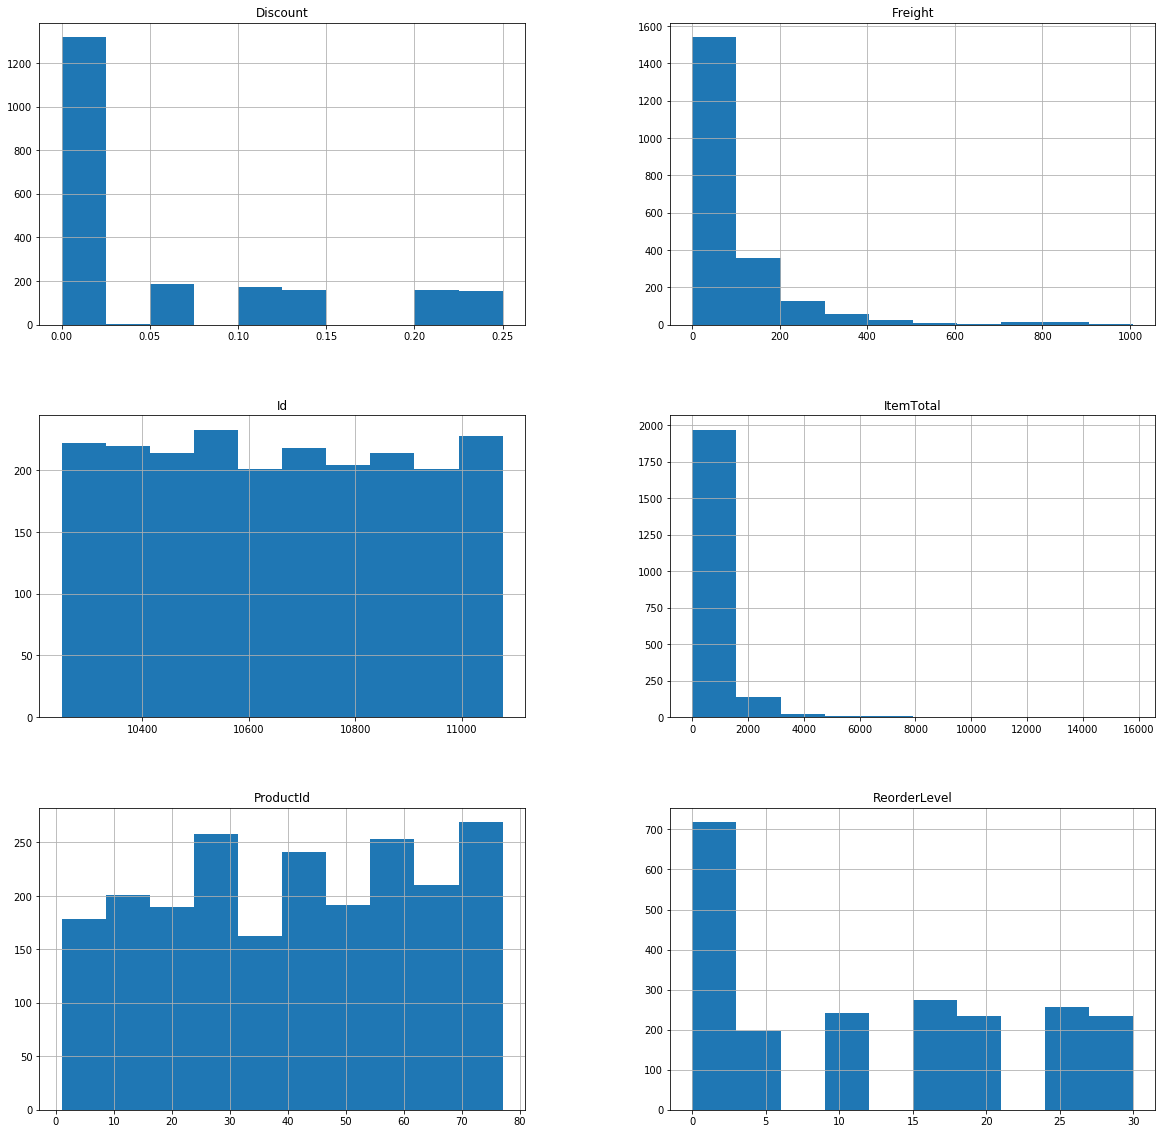

In [13]:
# visualize data
df.hist(figsize=(20,20));

### 2.2.3.2 Transform data<a id='Transform data'></a>

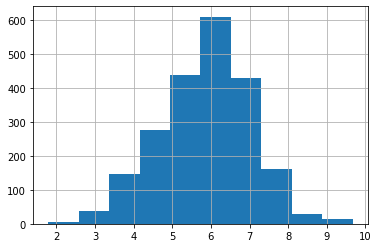

In [14]:
df['ItemTotal_log'] = df['ItemTotal'].map(lambda x: np.log(x))
df.ItemTotal_log.hist();

### 2.2.3.3 Sort data / Prepare data for testing<a id='Sort data'></a>

In [15]:
# sort data
df_reorder = df[df['ReorderLevel'] != 0]
df_reorder.head()

,Id,OrderDate,Freight,ReorderLevel,ItemTotal,ProductId,Discount,CompanyName,ItemTotal_log
0,10248,2012-07-04,32.38,30,252.0,11,0.00,Federal Shipping,5.529429
4,10249,2012-07-05,11.61,10,2120.0,51,0.00,Speedy Express,7.659171
5,10250,2012-07-08,65.83,10,96.5,41,0.00,United Package,4.569543
6,10250,2012-07-08,65.83,10,1855.0,51,0.15,United Package,7.525640
8,10251,2012-07-08,41.34,25,126.0,22,0.05,Speedy Express,4.836282


In [16]:
df_no_reorder = df[df['ReorderLevel'] == 0]
df_no_reorder.head()

,Id,OrderDate,Freight,ReorderLevel,ItemTotal,ProductId,Discount,CompanyName,ItemTotal_log
1,10248,2012-07-04,32.38,0,140.00,42,0.00,Federal Shipping,4.941642
2,10248,2012-07-04,32.38,0,174.00,72,0.00,Federal Shipping,5.159055
3,10249,2012-07-05,11.61,0,209.25,14,0.00,Speedy Express,5.343530
7,10250,2012-07-08,65.83,0,315.75,65,0.15,United Package,5.754951
10,10251,2012-07-08,41.34,0,421.00,65,0.00,Speedy Express,6.042633


In [17]:
# prepare data for testing
df['CompanyName'] = [x.replace(" ","") for x in df['CompanyName']]

### 2.2.3.4 Develop feature<a id='Develop feature'></a>

In [18]:
# create features
df_str = df.copy(deep=True)
df['Reorder'] = [1 if x != 0 else 0 for x in df['ReorderLevel']]
df_str['Reorder'] = ['Reorder' if x != 0 else 'No Reorder' for x in df['ReorderLevel']]
for x, y in enumerate(df_str['ReorderLevel']):
    if y == 0:
        df_str.loc[x,'ReorderLevel'] = 'Zero'
    elif y == 5:
        df_str.loc[x,'ReorderLevel'] = 'Five'
    elif y == 10:
        df_str.loc[x,'ReorderLevel'] = 'Ten'
    elif y == 15:
        df_str.loc[x,'ReorderLevel'] = 'Fifteen'
    elif y == 20:
        df_str.loc[x,'ReorderLevel'] = 'Twenty'
    elif y == 25:
        df_str.loc[x,'ReorderLevel'] = 'Twenty_Five'
    else:
        df_str.loc[x,'ReorderLevel'] = 'Thirty'
print(df.head())
print(df_str.head())

      Id   OrderDate  Freight  ReorderLevel  ItemTotal  ProductId  Discount  \
0  10248  2012-07-04    32.38            30     252.00         11       0.0   
1  10248  2012-07-04    32.38             0     140.00         42       0.0   
2  10248  2012-07-04    32.38             0     174.00         72       0.0   
3  10249  2012-07-05    11.61             0     209.25         14       0.0   
4  10249  2012-07-05    11.61            10    2120.00         51       0.0   

       CompanyName  ItemTotal_log  Reorder  
0  FederalShipping       5.529429        1  
1  FederalShipping       4.941642        0  
2  FederalShipping       5.159055        0  
3    SpeedyExpress       5.343530        0  
4    SpeedyExpress       7.659171        1  
      Id   OrderDate  Freight ReorderLevel  ItemTotal  ProductId  Discount  \
0  10248  2012-07-04    32.38       Thirty     252.00         11       0.0   
1  10248  2012-07-04    32.38         Zero     140.00         42       0.0   
2  10248  2012-07-04 

## 2.2.4 Model Data<a id='Model Data'></a>

- 2.2.4.1 Check for data normality
- 2.2.4.2 Standard deviation and other basic statistics
- 2.2.4.3 Statistical test
- 2.2.4.4 Verification techniques

### 2.2.4.1 Check for data normality<a id='Data normality'></a>

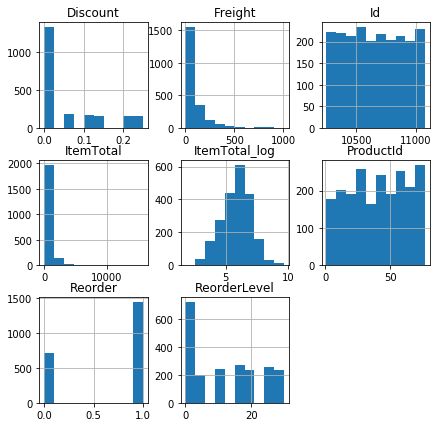

In [19]:
# visual/code for data normality
df.hist(figsize=(7,7));

### 2.2.4.2 Standard deviation and other basic statistics<a id='Standard deviation'></a>

In [51]:
# standard deviation for target variable
print('ItemTotal_log')
print('numbers of samples: ' + str(len(df['ItemTotal_log'])))
print('mean: ' + str(mean(df['ItemTotal_log'])))
print('standard deviation: ' + str(std(df['ItemTotal_log'])))
print('population variance: ' + str(std(df['ItemTotal_log'])**2))
print('skew: ' + str(df['ItemTotal_log'].skew()))
print('Reorder')
print('numbers of samples: ' + str(len(df['Reorder'])))
print('mean: ' + str(mean(df['Reorder'])))
print('standard deviation: ' + str(std(df['Reorder'])))
print('population variance: ' + str(std(df['Reorder'])**2))
print('skew: ' + str(df['Reorder'].skew()))

ItemTotal_log
numbers of samples: 2155
mean: 5.859902046483519
standard deviation: 1.164650382603087
population variance: 1.3564105136975169
skew: -0.1682796388327049
Reorder
numbers of samples: 2155
mean: 0.6668213457076566
standard deviation: 0.4713498049392686
population variance: 0.22217063861628655
skew: -0.7083383265426805


### 2.2.4.3 Statistical test<a id='Statistical test'></a>

In [21]:
# set up variables for this particular test
alpha = 0.05

In [52]:
# test
ols_results = sm.stats.anova_lm(ols('ItemTotal_log ~ CompanyName + Reorder', data=df_str).fit())
ols_results

,df,sum_sq,mean_sq,F,PR(>F)
CompanyName,2.0,0.612092,0.306046,0.236608,7.893213e-01
Reorder,1.0,140.189217,140.189217,108.381906,8.512698e-25
Residual,2151.0,2782.263348,1.293474,NaN,NaN


In [53]:
# result
companyName_pvalue = ols_results.loc['CompanyName', 'PR(>F)']
reorder_pvalue = ols_results.loc['Reorder', 'PR(>F)']

In [54]:
# evaluation of result
if alpha > companyName_pvalue:
    print('Reject the null hypothesis')
else:
    print('Fail to reject the null hypothesis')

Fail to reject the null hypothesis


In [55]:
# evaluation of result
if alpha > reorder_pvalue:
    print('Reject the null hypothesis')
else:
    print('Fail to reject the null hypothesis')

Reject the null hypothesis


Summarize results and determine next steps. Might include verification of sample size, error types, non-parametric testing, or a deepening of understanding

### 2.2.4.4 Verification techniques<a id='Verification techniques'></a>

#### 2.2.4.4.1 Nonparametric testing and confirmatory testing<a id='Nonparametric testing'></a>

##### Nonparametric testing

In [26]:
df['CompanyName'].unique()

array(['FederalShipping', 'SpeedyExpress', 'UnitedPackage'], dtype=object)

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 10 columns):
Id               2155 non-null int64
OrderDate        2155 non-null object
Freight          2155 non-null float64
ReorderLevel     2155 non-null int64
ItemTotal        2155 non-null float64
ProductId        2155 non-null int64
Discount         2155 non-null float64
CompanyName      2155 non-null object
ItemTotal_log    2155 non-null float64
Reorder          2155 non-null int64
dtypes: float64(4), int64(4), object(2)
memory usage: 168.5+ KB


In [28]:
# non-parametric testing variables
shipVia1 = df[df['CompanyName'] == 'FederalShipping']
shipVia1_reorder0 = shipVia1[shipVia1['Reorder'] == 0]['ItemTotal']
shipVia1_reorder1 = shipVia1[shipVia1['Reorder'] == 1]['ItemTotal']
shipVia2 = df[df['CompanyName'] == 'SpeedyExpress']
shipVia2_reorder0 = shipVia2[shipVia2['Reorder'] == 0]['ItemTotal']
shipVia2_reorder1 = shipVia2[shipVia2['Reorder'] == 1]['ItemTotal']
shipVia3 = df[df['CompanyName'] == 'UnitedPackage']
shipVia3_reorder0 = shipVia3[shipVia3['Reorder'] == 0]['ItemTotal']
shipVia3_reorder1 = shipVia3[shipVia3['Reorder'] == 1]['ItemTotal']

In [56]:
# non-parametric test
kruskal_stat, pvalue = stats.kruskal(shipVia1_reorder0, shipVia1_reorder1, shipVia2_reorder0, shipVia2_reorder1, shipVia3_reorder0, shipVia3_reorder1)
kruskal_stat, pvalue

(120.67769879906302, 2.2551786635363805e-24)

In [57]:
# evaluation of results
if alpha > pvalue:
    print('Reject the null hypothesis')
else:
    print('Fail to reject the null hypothesis')

Reject the null hypothesis


##### Confirmatory testing

In [32]:
# confirmatory test for ANOVA is TukeyHSD
tukey_results = pairwise_tukeyhsd(df_str['ItemTotal'], df_str['CompanyName']+df_str['Reorder'])
tukey_results.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
FederalShippingNo Reorder,FederalShippingReorder,-262.4791,0.0481,-523.6762,-1.2819,True
FederalShippingNo Reorder,SpeedyExpressNo Reorder,-93.8362,0.9,-395.788,208.1155,False
FederalShippingNo Reorder,SpeedyExpressReorder,-322.8532,0.0056,-583.539,-62.1674,True
FederalShippingNo Reorder,UnitedPackageNo Reorder,126.7029,0.7691,-155.4177,408.8235,False
FederalShippingNo Reorder,UnitedPackageReorder,-291.153,0.0114,-540.5522,-41.7537,True
FederalShippingReorder,SpeedyExpressNo Reorder,168.6428,0.4482,-94.1654,431.4511,False
FederalShippingReorder,SpeedyExpressReorder,-60.3741,0.9,-274.5012,153.753,False
FederalShippingReorder,UnitedPackageNo Reorder,389.182,0.001,149.4209,628.943,True
FederalShippingReorder,UnitedPackageReorder,-28.6739,0.9,-228.907,171.5592,False
SpeedyExpressNo Reorder,SpeedyExpressReorder,-229.0169,0.1269,-491.3169,33.2831,False


C:\Users\eannefawcett\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


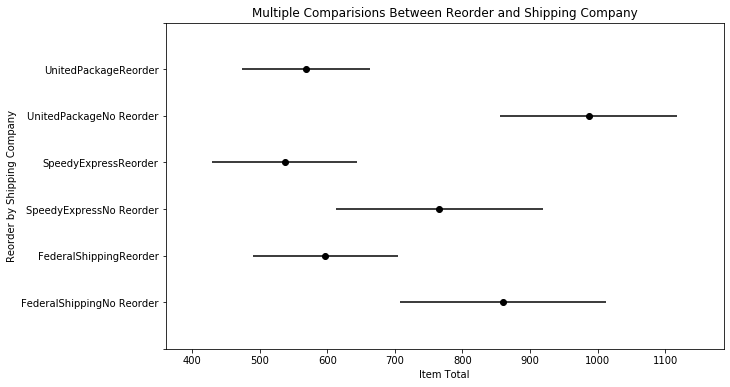

In [34]:
# create figure
fig05 = plt.figure(figsize=(5,4))
ax = fig05.add_subplot(111)

# run tukeys
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey_results = pairwise_tukeyhsd(df_str['ItemTotal'], df_str['CompanyName']+df_str['Reorder'])
tukey_plot = tukey_results.plot_simultaneous(ax=ax).show() 

# format plot
ax.axes.set_title('Multiple Comparisions Between Reorder and Shipping Company')
ax.axes.set_ylabel('Reorder by Shipping Company')
ax.axes.set_xlabel('Item Total');

Oberservations based on new finding

#### 2.2.4.4.2 Effect size<a id='Effect size'></a>
Cramers V

In [35]:
# effect size variables
combined_x = pd.DataFrame()
combined_x['values'] = df_str['CompanyName']+df_str['ReorderLevel']
from collections import Counter
unique_values = Counter(combined_x['values'])
for_chisquare = list(unique_values.values())
chisquare, pvalue = stats.chisquare(for_chisquare, ddof=1)
chisquare, pvalue

(708.2598607888631, 6.384329775450025e-138)

In [36]:
# effect size test cramersV
def cramersV(nrows, ncols, chisquared, correct_bias=True):
    import math
    nobs = nrows*ncols
    if correct_bias is True:
        phi = 0
    else:
        phi = chisquared/nobs
    V = math.sqrt((phi^2)/(min(nrows-1, ncols-1)))
    return np.array([V, phi])
effect_size, phi = cramersV(df_str.shape[0], df_str.shape[1], chisquare, correct_bias=True)
effect_size

0.4714045207910317

#### 2.2.4.4.3 Error<a id='Error'></a>

In [37]:
# power variables
effect_size, nobs1, alpha = effect_size, df['ItemTotal'].shape[0], alpha

In [38]:
# power test
power = tt_ind_solve_power(effect_size=effect_size, nobs1=nobs1, alpha=alpha)
power

1.0

In [39]:
# evaluation of power test
type_2_error = 1 - power
type_2_error

0.0

## 2.2.5 Interpret Model<a id='Interpret Model'></a>

### 2.2.5.1 Extension of acquired knowledge<a id='Extension'></a>
#### Deeper question
#### Hypothesis for deeper question

In [40]:
# deeper understanding variables already set

In [41]:
# deeper understanding test
anova_results = sm.stats.anova_lm(ols('ItemTotal ~ CompanyName + ReorderLevel', data=df).fit())
anova_results

,df,sum_sq,mean_sq,F,PR(>F)
CompanyName,2.0,3.445841e+06,1.722920e+06,1.410746,0.244187
ReorderLevel,1.0,2.476820e+07,2.476820e+07,20.280477,0.000007
Residual,2151.0,2.626980e+09,1.221283e+06,NaN,NaN


In [42]:
# deeper understanding result
companyName_anova_pvalue = anova_results.loc['CompanyName', 'PR(>F)']
reorderLevel_anova_pvalue = anova_results.loc['ReorderLevel', 'PR(>F)']

In [43]:
# deeper understanding evaluation of result
if alpha > companyName_anova_pvalue:
    print('Reject the null hypothesis')
else:
    print('Fail to reject the null hypothesis')

Fail to reject the null hypothesis


In [44]:
if alpha > reorderLevel_anova_pvalue:
    print('Reject the null hypothesis')
else:
    print('Fail to reject the null hypothesis')

Reject the null hypothesis


In [45]:
# non-parametric testing variables
shipVia1 = df[df['CompanyName'] == 'FederalShipping']
shipVia1_reorder0 = shipVia1[shipVia1['ReorderLevel'] == 0]['ItemTotal']
shipVia1_reorder5 = shipVia1[shipVia1['ReorderLevel'] == 5]['ItemTotal']
shipVia1_reorder10 = shipVia1[shipVia1['ReorderLevel'] == 10]['ItemTotal']
shipVia1_reorder15 = shipVia1[shipVia1['ReorderLevel'] == 15]['ItemTotal']
shipVia1_reorder20 = shipVia1[shipVia1['ReorderLevel'] == 20]['ItemTotal']
shipVia1_reorder25 = shipVia1[shipVia1['ReorderLevel'] == 25]['ItemTotal']
shipVia1_reorder30 = shipVia1[shipVia1['ReorderLevel'] == 30]['ItemTotal']
shipVia2 = df[df['CompanyName'] == 'SpeedyExpress']
shipVia2_reorder0 = shipVia2[shipVia2['ReorderLevel'] == 0]['ItemTotal']
shipVia2_reorder5 = shipVia2[shipVia2['ReorderLevel'] == 5]['ItemTotal']
shipVia2_reorder10 = shipVia2[shipVia2['ReorderLevel'] == 10]['ItemTotal']
shipVia2_reorder15 = shipVia2[shipVia2['ReorderLevel'] == 15]['ItemTotal']
shipVia2_reorder20 = shipVia2[shipVia2['ReorderLevel'] == 20]['ItemTotal']
shipVia2_reorder25 = shipVia2[shipVia2['ReorderLevel'] == 25]['ItemTotal']
shipVia2_reorder30 = shipVia2[shipVia2['ReorderLevel'] == 30]['ItemTotal']
shipVia3 = df[df['CompanyName'] == 'UnitedPackage']
shipVia3_reorder0 = shipVia3[shipVia3['ReorderLevel'] == 0]['ItemTotal']
shipVia3_reorder5 = shipVia3[shipVia3['ReorderLevel'] == 5]['ItemTotal']
shipVia3_reorder10 = shipVia3[shipVia3['ReorderLevel'] == 10]['ItemTotal']
shipVia3_reorder15 = shipVia3[shipVia3['ReorderLevel'] == 15]['ItemTotal']
shipVia3_reorder20 = shipVia3[shipVia3['ReorderLevel'] == 20]['ItemTotal']
shipVia3_reorder25 = shipVia3[shipVia3['ReorderLevel'] == 25]['ItemTotal']
shipVia3_reorder30 = shipVia3[shipVia3['ReorderLevel'] == 30]['ItemTotal']

In [46]:
# non-parametric test
kruskal_results = stats.kruskal(shipVia1_reorder0, shipVia1_reorder5, shipVia1_reorder10, shipVia1_reorder15, shipVia1_reorder20, 
                                shipVia1_reorder25, shipVia1_reorder30, shipVia2_reorder0, shipVia2_reorder5, shipVia2_reorder10, 
                                shipVia2_reorder15, shipVia2_reorder20, shipVia2_reorder25, shipVia2_reorder30, shipVia3_reorder0, 
                                shipVia3_reorder5, shipVia3_reorder10, shipVia3_reorder15, shipVia3_reorder20, shipVia3_reorder25, 
                                shipVia3_reorder30)
kruskal_results

KruskalResult(statistic=191.1760174190746, pvalue=6.208124121397785e-30)

In [47]:
# result
p_value = kruskal_results[1]
p_value

6.208124121397785e-30

In [48]:
if alpha > p_value:
    print('Reject the null hypothesis')
else:
    print('Fail to reject the null hypothesis')

Reject the null hypothesis


In [49]:
tukey_results = pairwise_tukeyhsd(df_str['ItemTotal'], df_str['CompanyName']+df_str['ReorderLevel'])
tukey_results.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
FederalShippingFifteen,FederalShippingFive,-956.5566,0.001,-1594.6462,-318.4671,True
FederalShippingFifteen,FederalShippingTen,-634.054,0.0372,-1252.5269,-15.5811,True
FederalShippingFifteen,FederalShippingThirty,-700.6749,0.0114,-1328.472,-72.8778,True
FederalShippingFifteen,FederalShippingTwenty,-741.8032,0.0063,-1382.6356,-100.9709,True
FederalShippingFifteen,FederalShippingTwenty_Five,-797.1815,0.0013,-1429.9943,-164.3686,True
FederalShippingFifteen,FederalShippingZero,-349.9929,0.5842,-848.1693,148.1836,False
FederalShippingFifteen,SpeedyExpressFifteen,-440.4663,0.5438,-1052.5003,171.5677,False
FederalShippingFifteen,SpeedyExpressFive,-812.2508,0.0046,-1500.8869,-123.6147,True
FederalShippingFifteen,SpeedyExpressTen,-730.3703,0.0042,-1346.6472,-114.0934,True
FederalShippingFifteen,SpeedyExpressThirty,-496.2385,0.3621,-1124.0356,131.5587,False


C:\Users\eannefawcett\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  import sys


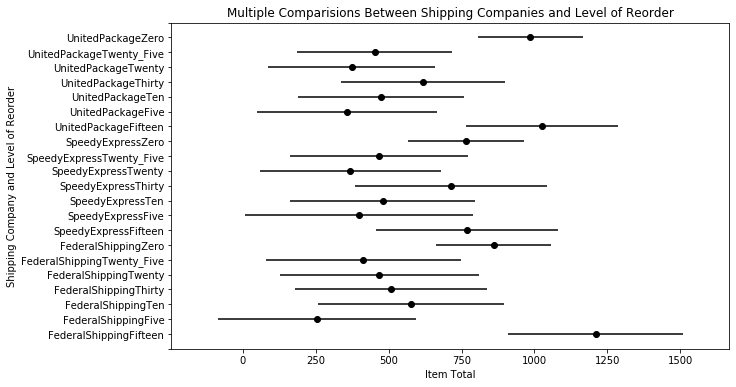

In [50]:
# create figure
fig06 = plt.figure(figsize=(5,4))
ax = fig06.add_subplot(111)

# run tukeys
tukey_results = pairwise_tukeyhsd(df_str['ItemTotal'], df_str['CompanyName']+df_str['ReorderLevel'])
tukey_plot = tukey_results.plot_simultaneous(ax=ax).show() 

# format plot
ax.axes.set_title('Multiple Comparisions Between Shipping Companies and Level of Reorder')
ax.axes.set_ylabel('Shipping Company and Level of Reorder')
ax.axes.set_xlabel('Item Total')
plt.show();

# 2.3 Results<a id='Results'></a>

# 2.4 Conclusions<a id='Conclusions'></a>

- 2.4.1 Actionable Items and Insights
- 2.4.2 Additional Visuals

## 2.4.1 Actionable Items and Insights<a id='Actionable Items and Insights'></a>

YES, REORDER LOWERS CUSTOMER SPENDING

TRY TO MOVE CLIENTS TO A REORDER LEVEL OF 15; DISCOURAGE CLIENTS FROM A REORDER LEVEL OF 5

## 2.4.2 Additional Visuals<a id='Additional Visuals'></a>

# 2.5 Future Work<a id='Future Work'></a>

Confirm that using a reorder level of 15 will be advantageous for the company.

# 2.6 References<a id='References'></a>
https://en.wikipedia.org/wiki/Effect_size#Categorical_family:_Effect_sizes_for_associations_among_categorical_variables
https://machinelearningmastery.com/chi-squared-test-for-machine-learning/
https://gist.github.com/dtemkin/04e653c8f19e8ac0c4965b797ba2af2b